In [15]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [16]:
wind_table = Table.read('wind_data.ecsv').to_pandas()
shake_table = Table.read('wind_shake.ecsv').to_pandas()
exposure_table = Table.read('exposure_data.ecsv').to_pandas()

In [17]:
wind_table[:2], len(wind_table)

(            MJD           TIMESTAMP  WIND_SPEED  WIND_DIRECTION       GUST
 0  58569.131042 2019-03-27 03:08:42   17.200001      168.000000  99.300003
 1  58569.132477 2019-03-27 03:10:46   14.300000      175.699997  99.300003,
 1036477)

In [18]:
shake_table[:2], len(shake_table)

(            MJD           TIMESTAMP  WIND_GUST  WIND_SHAKE
 0  59307.129074 2021-04-03 03:05:52          1           0
 1  59307.129213 2021-04-03 03:06:04          1           1,
 102178)

In [19]:
exposure_table[:2], len(exposure_table)

(   EXPID           MJD                  TIMESTAMP      EXPTIME SURVEY PROGRAM  \
 0  90224  59364.148239 2021-05-30 03:33:27.849600   348.878632    sv3  BACKUP   
 1  90225  59364.154715 2021-05-30 03:42:47.376000  1054.206299    sv3  BRIGHT   
 
     MOUNT_EL    MOUNT_AZ  
 0  81.250550  143.299106  
 1  56.109587  201.243202  ,
 20484)

In [20]:
set(exposure_table['PROGRAM'])

{'BACKUP', 'BRIGHT', 'DARK'}

In [21]:
def calculate_angle_difference(angle1, angle2):
    """
    Calculate the absolute angular difference between two angles in degrees,
    considering the circular nature of angles (0-360 degrees).
    
    Parameters:
    -----------
    angle1, angle2 : float
        Angles in degrees
        
    Returns:
    --------
    float
        Absolute angular difference in degrees (0-180)
    """
    diff = abs(angle1 - angle2) % 360
    return min(diff, 360 - diff)

def add_wind_statistics(exposure_table, shake_table, wind_table):
    """
    Add columns to exposure_table containing wind statistics from both shake_table 
    and wind_table within each exposure's time window, including the opening angle
    between wind direction and telescope pointing.
    
    Parameters:
    -----------
    exposure_table : pandas.DataFrame
        Table containing exposure information with columns:
        MJD, TIMESTAMP, PROGRAM, MOUNT_AZ
    shake_table : pandas.DataFrame
        Table containing wind shake information with columns:
        MJD, TIMESTAMP, WIND_GUST, WIND_SHAKE
    wind_table : pandas.DataFrame
        Table containing wind measurements with columns:
        MJD, TIMESTAMP, WIND_SPEED, WIND_DIRECTION, GUST
        
    Returns:
    --------
    pandas.DataFrame
        exposure_table with additional wind statistics columns
    """
    # Create a copy of the exposure table to avoid modifying the original
    result_table = exposure_table.copy()
    
    # Define window lengths in seconds for each program type
    window_lengths = {
        'BACKUP': 300,
        'BRIGHT': 600,
        'DARK': 1200
    }
    
    # Initialize new columns with zeros
    new_columns = [
        'WIND_GUST_SUM', 'WIND_SHAKE_SUM',  # From shake_table
        'WIND_SPEED_AVG', 'WIND_SPEED_STD',  # From wind_table
        'WIND_DIRECTION_AVG', 'WIND_DIRECTION_STD',
        'GUST_AVG', 'GUST_STD',
        'WIND_OPENING_ANGLE'  
    ]
    for col in new_columns:
        result_table[col] = 0.0
    
    # Convert timestamps to pandas datetime
    shake_times = pd.to_datetime(shake_table['TIMESTAMP'])
    wind_times = pd.to_datetime(wind_table['TIMESTAMP'])
    
    # Process each exposure
    for i in range(len(result_table)):
        if((i%1000)==0):
            print(i, len(result_table))
        # Get the current row
        row = result_table.iloc[i]
        
        # Get the end time of the exposure
        start_time = pd.to_datetime(row['TIMESTAMP'])
        
        # Calculate start time based on the program type
        window_length = row['EXPTIME']
        end_time = start_time + pd.Timedelta(seconds=window_length)
        
        # Find all shake_table entries within this time window
        shake_mask = (shake_times >= start_time) & (shake_times <= end_time)
        shake_window = shake_table[shake_mask]
        
        # Calculate statistics from shake_table
        result_table.iloc[i, result_table.columns.get_loc('WIND_GUST_SUM')] = shake_window['WIND_GUST'].sum()
        result_table.iloc[i, result_table.columns.get_loc('WIND_SHAKE_SUM')] = shake_window['WIND_SHAKE'].sum()
        
        # Find all wind_table entries within this time window
        wind_mask = (wind_times >= start_time) & (wind_times <= end_time)
        wind_window = wind_table[wind_mask]
        
        # Calculate statistics from wind_table
        if len(wind_window) > 0:  # Only calculate if we have data points
            # Wind speed statistics
            result_table.iloc[i, result_table.columns.get_loc('WIND_SPEED_AVG')] = wind_window['WIND_SPEED'].mean()
            result_table.iloc[i, result_table.columns.get_loc('WIND_SPEED_STD')] = wind_window['WIND_SPEED'].std()
            
            # Wind direction statistics
            result_table.iloc[i, result_table.columns.get_loc('WIND_DIRECTION_AVG')] = wind_window['WIND_DIRECTION'].mean()
            result_table.iloc[i, result_table.columns.get_loc('WIND_DIRECTION_STD')] = wind_window['WIND_DIRECTION'].std()
            
            # Gust statistics
            result_table.iloc[i, result_table.columns.get_loc('GUST_AVG')] = wind_window['GUST'].mean()
            result_table.iloc[i, result_table.columns.get_loc('GUST_STD')] = wind_window['GUST'].std()
            
            # Calculate opening angle between wind direction and telescope pointing
            wind_direction_avg = wind_window['WIND_DIRECTION'].mean()
            telescope_az = row['MOUNT_AZ']
            opening_angle = calculate_angle_difference(wind_direction_avg, telescope_az)
            result_table.iloc[i, result_table.columns.get_loc('WIND_OPENING_ANGLE')] = opening_angle
    
    return result_table

In [24]:
new_exposure_table = add_wind_statistics(exposure_table, shake_table, wind_table)

0 20484
1000 20484
2000 20484
3000 20484
4000 20484
5000 20484
6000 20484
7000 20484
8000 20484
9000 20484
10000 20484
11000 20484
12000 20484
13000 20484
14000 20484
15000 20484
16000 20484
17000 20484
18000 20484
19000 20484
20000 20484


In [25]:
new_exposure_astropy = Table.from_pandas(new_exposure_table)
new_exposure_astropy.write('extended_exposure_data.ecsv', format='ascii.ecsv', overwrite=True)

In [10]:
new_exposure_table = Table.read('extended_exposure_data.ecsv').to_pandas()

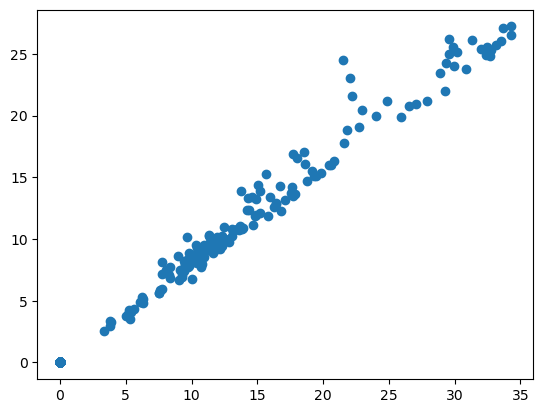

In [11]:
plt.scatter(new_exposure_table['WIND_SPEED_AVG'],new_exposure_table['GUST_AVG'])

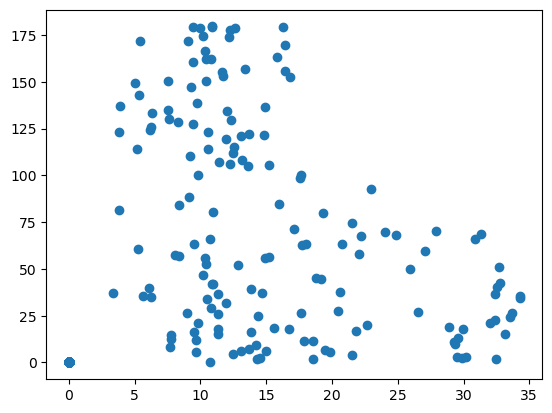

In [12]:
plt.scatter(new_exposure_table['WIND_SPEED_AVG'],new_exposure_table['WIND_OPENING_ANGLE'])

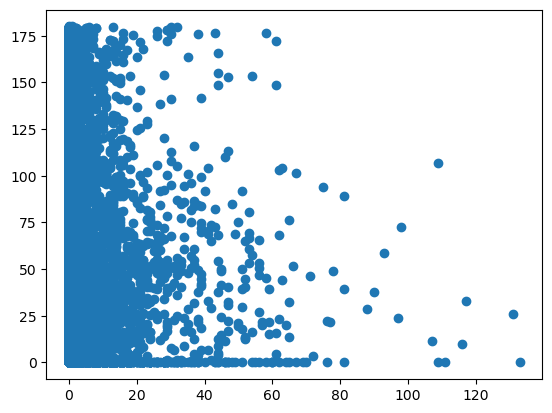

In [22]:
plt.scatter(new_exposure_table['WIND_SHAKE_SUM'],new_exposure_table['WIND_OPENING_ANGLE'])

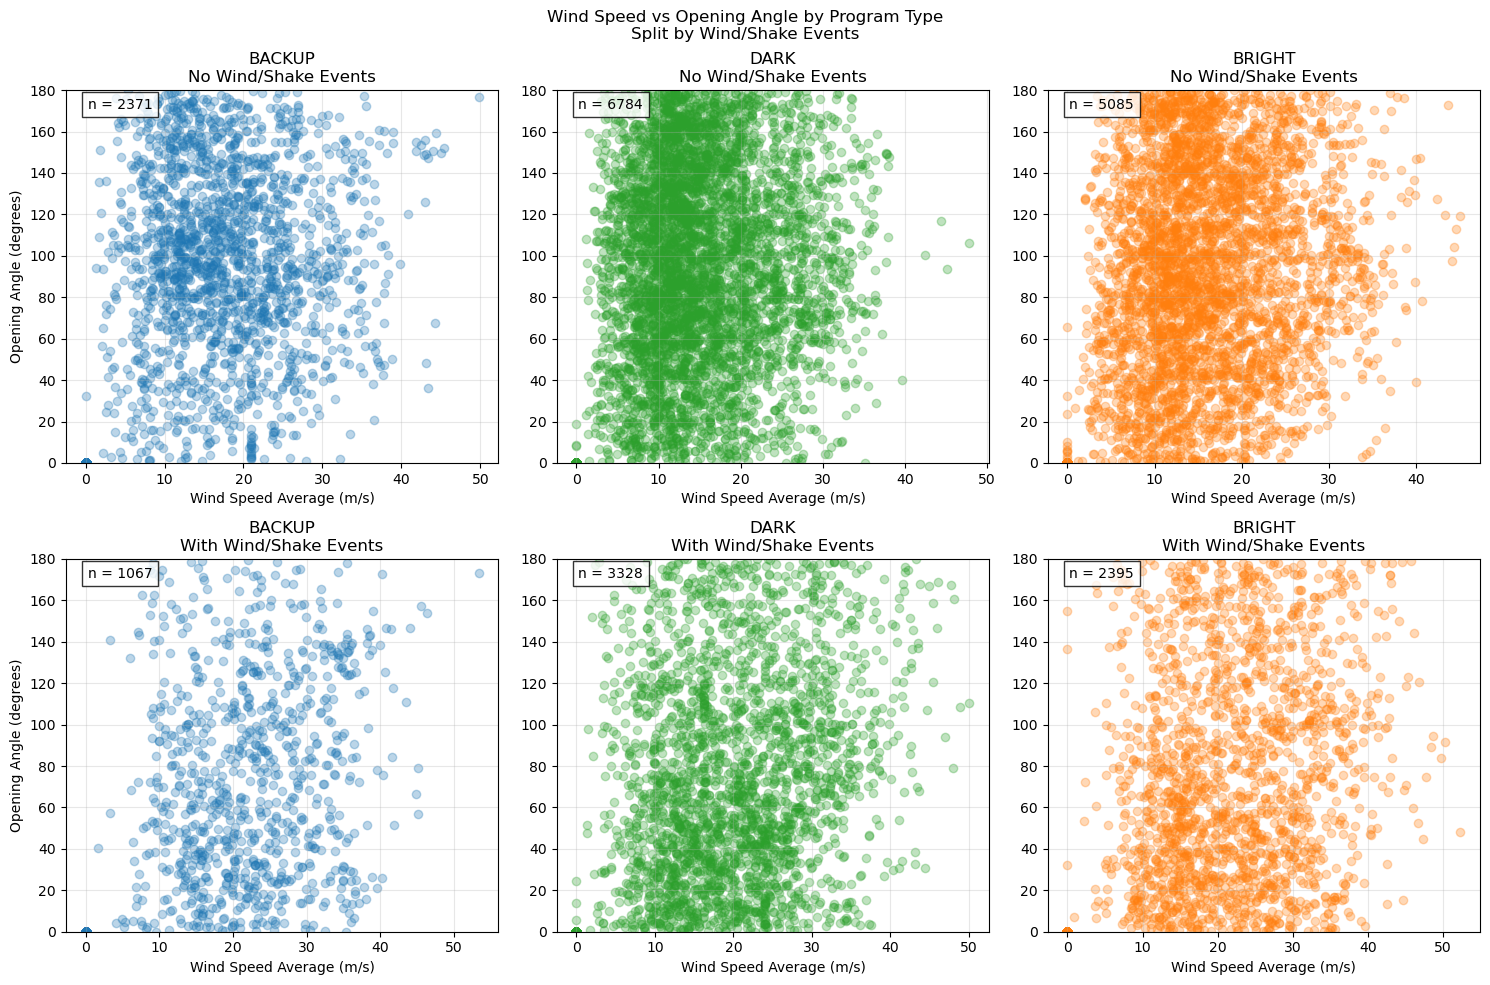

In [38]:
def plot_wind_speed_vs_angle_split(df):
    """
    Create a six-panel scatter plot of wind speed vs opening angle,
    separated by program type and presence/absence of wind/shake events.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 
        PROGRAM, WIND_SPEED_AVG, WIND_OPENING_ANGLE, WIND_GUST_SUM, WIND_SHAKE_SUM
    """
    # Set up the figure and subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Wind Speed vs Opening Angle by Program Type\nSplit by Wind/Shake Events')
    
    # Define colors and programs
    programs = ['BACKUP', 'DARK', 'BRIGHT']
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e']  # blue, green, orange
    
    # Create scatter plot for each program and condition
    for col, (program, color) in enumerate(zip(programs, colors)):
        for row, has_events in enumerate([False, True]):
            ax = axes[row, col]
            
            # Create mask for program and wind/shake condition
            program_mask = df['PROGRAM'] == program
            if has_events:
                event_mask = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) > 0
                title_prefix = 'With'
            else:
                event_mask = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) == 0
                title_prefix = 'No'
            
            combined_mask = program_mask & event_mask
            program_data = df[combined_mask]
            
            # Create scatter plot
            ax.scatter(program_data['WIND_SPEED_AVG'], 
                      program_data['WIND_OPENING_ANGLE'],
                      alpha=0.3, c=color, label=program)
            
            # Add labels
            ax.set_xlabel('Wind Speed Average (m/s)')
            if col == 0:
                ax.set_ylabel('Opening Angle (degrees)')
            ax.set_title(f'{program}\n{title_prefix} Wind/Shake Events')
            
            # Set y-axis limits
            ax.set_ylim(0, 180)
            
            # Add grid
            ax.grid(True, alpha=0.3)
            
            # Add count of points
            count = len(program_data)
            ax.text(0.05, 0.95, f'n = {count}', 
                    transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8))
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig('summary.jpg')
    return fig, axes

# Create the plot
fig, axes = plot_wind_speed_vs_angle_split(new_exposure_table)

# Display the plot
#plt.show()

In [35]:
def plot_cumulative_distributions(df):
    """
    Create three-panel plot showing cumulative distributions of wind speed,
    opening angle, and wind gust sum for each program type.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 
        PROGRAM, WIND_SPEED_AVG, WIND_OPENING_ANGLE, WIND_GUST_SUM
    """
    # Set up the figure and subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Cumulative Distributions by Program Type')
    
    # Define colors and programs
    programs = ['BACKUP', 'DARK', 'BRIGHT']
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e']  # blue, green, orange
    
    # Variables to plot with their labels
    variables = ['WIND_SPEED_AVG', 'WIND_OPENING_ANGLE', 'WIND_SHAKE_SUM']
    xlabels = ['Wind Speed (m/s)', 'Opening Angle (degrees)', 'Wind Shake Sum']
    
    # Create plots for each variable
    for ax, var, xlabel in zip(axes, variables, xlabels):
        for program, color in zip(programs, colors):
            # Get data for this program
            mask = df['PROGRAM'] == program
            data = df[mask][var].dropna()
            
            # Sort data and calculate cumulative distribution
            sorted_data = np.sort(data)
            cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            
            # Plot
            ax.plot(sorted_data, cumulative, 
                   label=f'{program} (n={len(data)})',
                   color=color, linewidth=2)
        
        # Customize each subplot
        ax.grid(True, alpha=0.3)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Cumulative Fraction' if ax == axes[0] else '')
        ax.legend()
        
        # Set y-axis limits
        ax.set_ylim(0, 1.05)
        
    # Adjust layout
    plt.tight_layout()
    
    return fig, axes

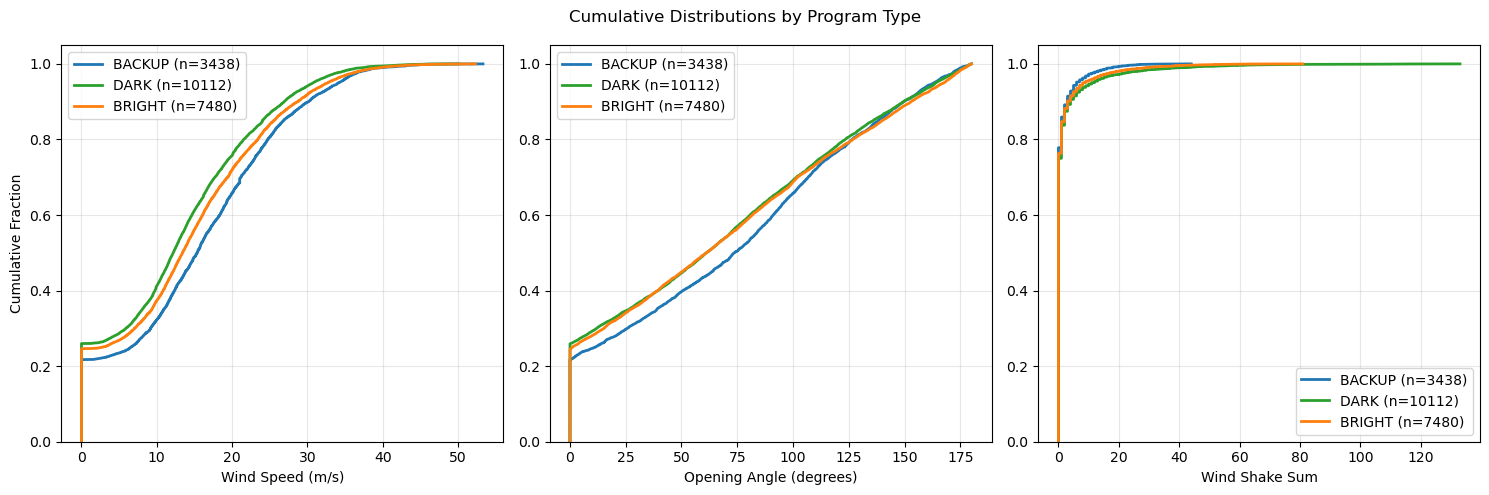

In [36]:
# Create the plot
fig, axes = plot_cumulative_distributions(new_exposure_table)

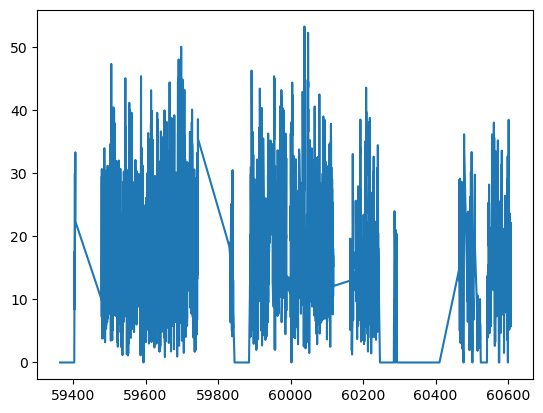

In [34]:
plt.plot(new_exposure_table['MJD'], new_exposure_table['WIND_SPEED_AVG'])

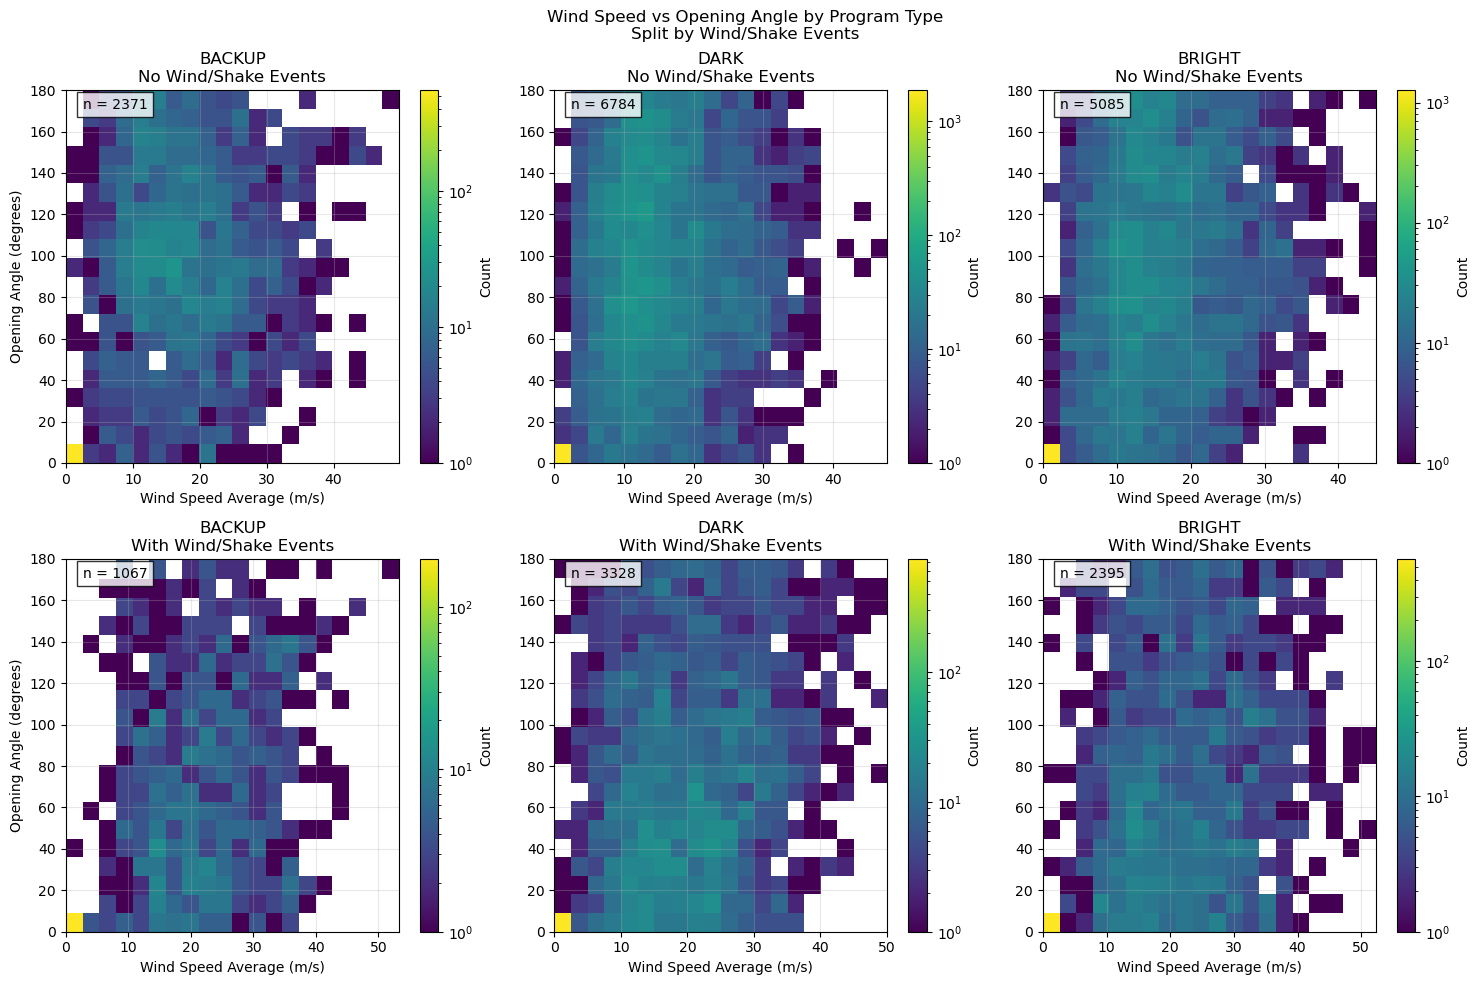

In [39]:
def plot_wind_speed_vs_angle_2dhist(df):
    """
    Create a six-panel 2D histogram of wind speed vs opening angle,
    separated by program type and presence/absence of wind/shake events.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 
        PROGRAM, WIND_SPEED_AVG, WIND_OPENING_ANGLE, WIND_GUST_SUM, WIND_SHAKE_SUM
    """
    # Set up the figure and subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Wind Speed vs Opening Angle by Program Type\nSplit by Wind/Shake Events')
    
    # Define colors and programs
    programs = ['BACKUP', 'DARK', 'BRIGHT']
    
    # Create histogram for each program and condition
    for col, program in enumerate(programs):
        for row, has_events in enumerate([False, True]):
            ax = axes[row, col]
            
            # Create mask for program and wind/shake condition
            program_mask = df['PROGRAM'] == program
            if has_events:
                event_mask = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) > 0
                title_prefix = 'With'
            else:
                event_mask = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) == 0
                title_prefix = 'No'
            
            combined_mask = program_mask & event_mask
            program_data = df[combined_mask]
            
            # Create 2D histogram
            hist = ax.hist2d(program_data['WIND_SPEED_AVG'], 
                           program_data['WIND_OPENING_ANGLE'],
                           bins=(20, 20),  # You can adjust the number of bins
                           cmap='viridis',
                           norm=plt.matplotlib.colors.LogNorm())  # Use log scale for better visualization
            
            # Add colorbar
            plt.colorbar(hist[3], ax=ax, label='Count')
            
            # Add labels
            ax.set_xlabel('Wind Speed Average (m/s)')
            if col == 0:
                ax.set_ylabel('Opening Angle (degrees)')
            ax.set_title(f'{program}\n{title_prefix} Wind/Shake Events')
            
            # Set y-axis limits
            ax.set_ylim(0, 180)
            
            # Add grid
            ax.grid(True, alpha=0.3)
            
            # Add count of points
            count = len(program_data)
            ax.text(0.05, 0.95, f'n = {count}', 
                    transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8))
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    return fig, axes

# Create the plot
fig, axes = plot_wind_speed_vs_angle_2dhist(new_exposure_table)
